<a href="https://colab.research.google.com/github/cosmolejo/DeepNLP_Forecasting/blob/main/Aracataca_base_M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation of packages (Chronos and AutoGluon)

In [1]:
%%capture
!pip install chronos-forecasting
!pip install autogluon

## Imports

In [1]:
# Data
import matplotlib.pyplot as plt
import pandas as pd

# Deep learning
import torch
from chronos import BaseChronosPipeline
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

use_cuda = torch.cuda.is_available()
print("Is cuda available?", use_cuda, f"\nYou can{'not' if not use_cuda else ''} run original Chronos models of size small and above")

Is cuda available? True 
You can run original Chronos models of size small and above


## Global functions

In [2]:
def plot_timeseries_forecasting(df, low, median, high, timestamp_column = 'Month',
                                target_column = '#Passengers',
                                prediction_interval = .8, prediction_length = 12,
                                figsize=(8,4)):
    historical_data = df[target_column]
    years_data = pd.to_datetime(df[timestamp_column])

    forecast_index = pd.date_range(start=years_data.iloc[-1], periods=prediction_length + 1, freq="MS")[1:]
    plt.figure(figsize=figsize)
    plt.plot(years_data, historical_data,
             color="royalblue", label="Historical data")
    plt.plot(forecast_index, median, color="tomato", label="Median forecast")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3,
                     label=f"{prediction_interval * 100}% prediction interval")
    plt.legend()
    plt.grid()
    plt.show()

# Example with Chronos repo

In [4]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"
)
df['#Passengers'].head()

,#Passengers
0,112
1,118
2,132
3,129
4,121


In [5]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cuda",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# quantiles is an fp32 tensor with shape [batch_size, prediction_length, num_quantile_levels]
# mean is an fp32 tensor with shape [batch_size, prediction_length]
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(df["#Passengers"]),
    prediction_length=12,
    quantile_levels=[0.1, 0.5, 0.9],
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [6]:
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

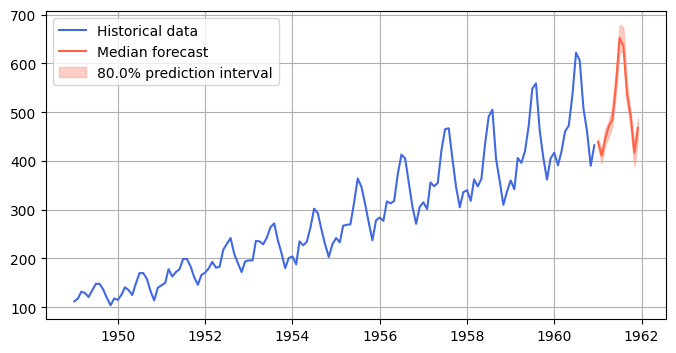

In [7]:
plot_timeseries_forecasting(df, low, median, high)

# Example with AutoGluon library
Let's use `autogluon` which is for reliable production use (Suggested by the paper's writers) to do the same forecasting

AutoGluon expects time series data in long formar. Each row of the data frame contains a single observation (timestep) of a single time series representes by
- Unique ID of the time series (`"item_id"`) as `int` or `str`
- Timestamp of the observation (`"timestamp"`) as a `pandas.Timeststamp` or compatible format
- Numeric value of the time series (`"target"`)

The raw dataset should always follow this format with at least three columns for unique ID, timestamp, and target value, but names of these columns can be arbitrary. It is important, however, that we provide the names of the columns when constructing a `TimeSeriesDataFrame` that is used by AutoGluon. AutoGluon will raise an exception if the data doesn't match the expected format.

In [8]:
# This is only one time series, so let's set the unique ID
df['id_time_series'] = '0'

In [9]:
# We need to rename the target column as "target"
df.rename(columns={"#Passengers": "target"}, inplace = True)
df.head()

,Month,target,id_time_series
0,1949-01,112,0
1,1949-02,118,0
2,1949-03,132,0
3,1949-04,129,0
4,1949-05,121,0


In [10]:
# Now we can create the TimeSeriesDataFrame
train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="id_time_series",
    timestamp_column="Month"
)
train_data.head()

target
item_id timestamp         
0       1949-01-01     112
        1949-02-01     118
        1949-03-01     132
        1949-04-01     129
        1949-05-01     121

In [11]:
print(f"We will use {'chronos_small' if use_cuda else 'bolt_small'} because cuda is {'not ' if not use_cuda else ''}available")

We will use chronos_small because cuda is available


In [12]:
prediction_length = 12
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="chronos_small" if use_cuda else "bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/AutogluonModels/ag-20250413_155401'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       9.85 GB / 12.67 GB (77.7%)
Disk Space Avail:   66.89 GB / 112.64 GB (59.4%)
Setting presets to: chronos_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 12,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 144 rows,

Model not specified in predict, will default to the model with the best validation score: Chronos[small]


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

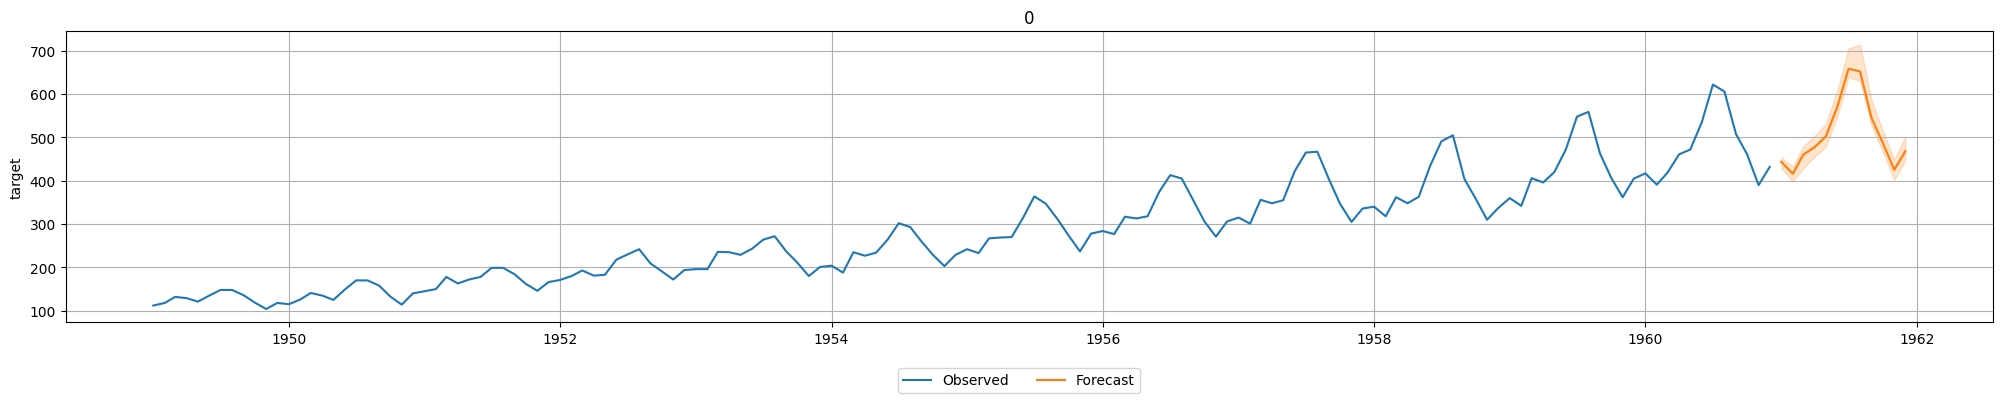

In [13]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=train_data,
    predictions=predictions,
    item_ids=train_data.item_ids[0],
    max_history_length=200,
);

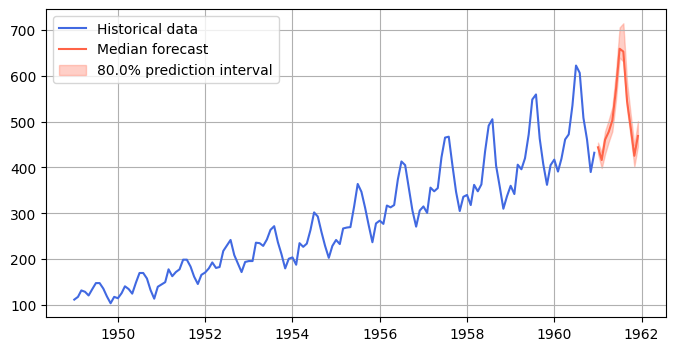

In [15]:
low, median, high = predictions.loc[:, "0.1"], predictions.loc[:, "0.5"], predictions.loc[:, "0.9"]
plot_timeseries_forecasting(df, low, median, high, target_column='target')

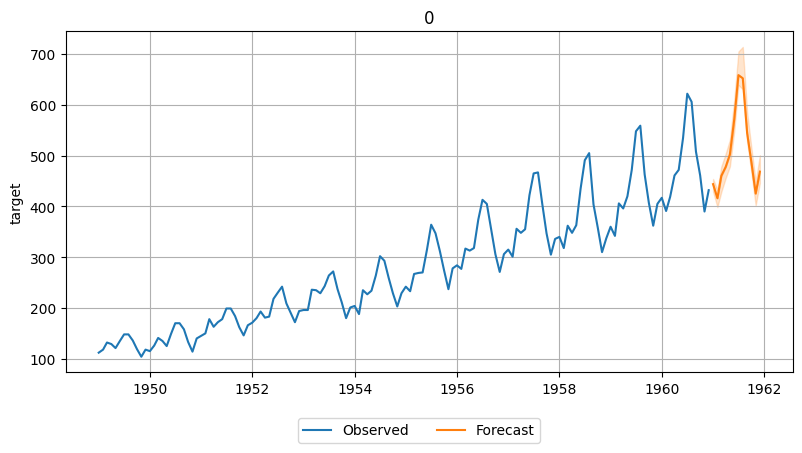

In [16]:
predictor.plot(train_data, predictions, quantile_levels=[0.1, 0.9], matplotlib_rc_params={'figure.figsize': (8, 4)});